<div><img style="float: right; width: 120px; vertical-align:rigth" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />



<h1><center>ResNet50 Transfer Learning on Stanford Cars Dataset</center></h1>

<center>Proyecto de Ciencia de Datos</center>
<center>Grado en Ciencia de Datos e Inteligencia Artificial</center>
<center>Escuela Técnica Superior de Ingeniería de Sistemas Informáticos</center>
<center>2023-2024</center>



En el siguiente notebook se muestra el proceso de entrenamiento de una red neuronal convolucional para la clasificación de imágenes de coches. Para ello se ha utilizado la arquitectura [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50) preentrenada con el dataset [ImageNet](https://www.image-net.org/) de la librería de TensorFlow. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Import Libraries

In [2]:
import os

# Obtain current working directory
os.chdir('..')

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from settings import settings

from models.tl_resnet_50 import ResNet50_TL
from auxiliar_functions.img_generator import  create_img_generator
from auxiliar_functions.plot_functions import plot_samples, plot_comparison

In [5]:
# Check if GPU is running
print(len(tf.config.list_physical_devices('GPU')) > 0)

# See GPU devices in use
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Set memory growth to True. This will allow to allocate memory as needed
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# Get train and test paths
train_path, test_path = settings.train, settings.test

# Load train and test data
train = pd.read_csv(settings.data_train, header=None)
test = pd.read_csv(settings.data_test, header=None)
train.shape, test.shape

((8144, 6), (8041, 6))

In [7]:
# Load model names
model_names = pd.read_csv(settings.car_model, header=None)[0].tolist()

# Correct model names for them to be turned into folder name
model_names = [name.replace('/', '-') for name in model_names]

print(len(model_names), '\n', model_names[:5])

196 
 ['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012']


In [8]:
# Change Column Names
train.columns = test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']
test.columns = ['img_name', 'x', 'y', 'width', 'height', 'label']

# For each item in df, find the corresponding model name
train['model'] = train.label.apply(lambda x: model_names[x-1])
test['model'] = test.label.apply(lambda x: model_names[x-1])

# Correct model names for them to be turned into folder name
train['model'] = train.model.apply(lambda x: x.replace('/', '-'))
test['model'] = test.model.apply(lambda x: x.replace('/', '-'))

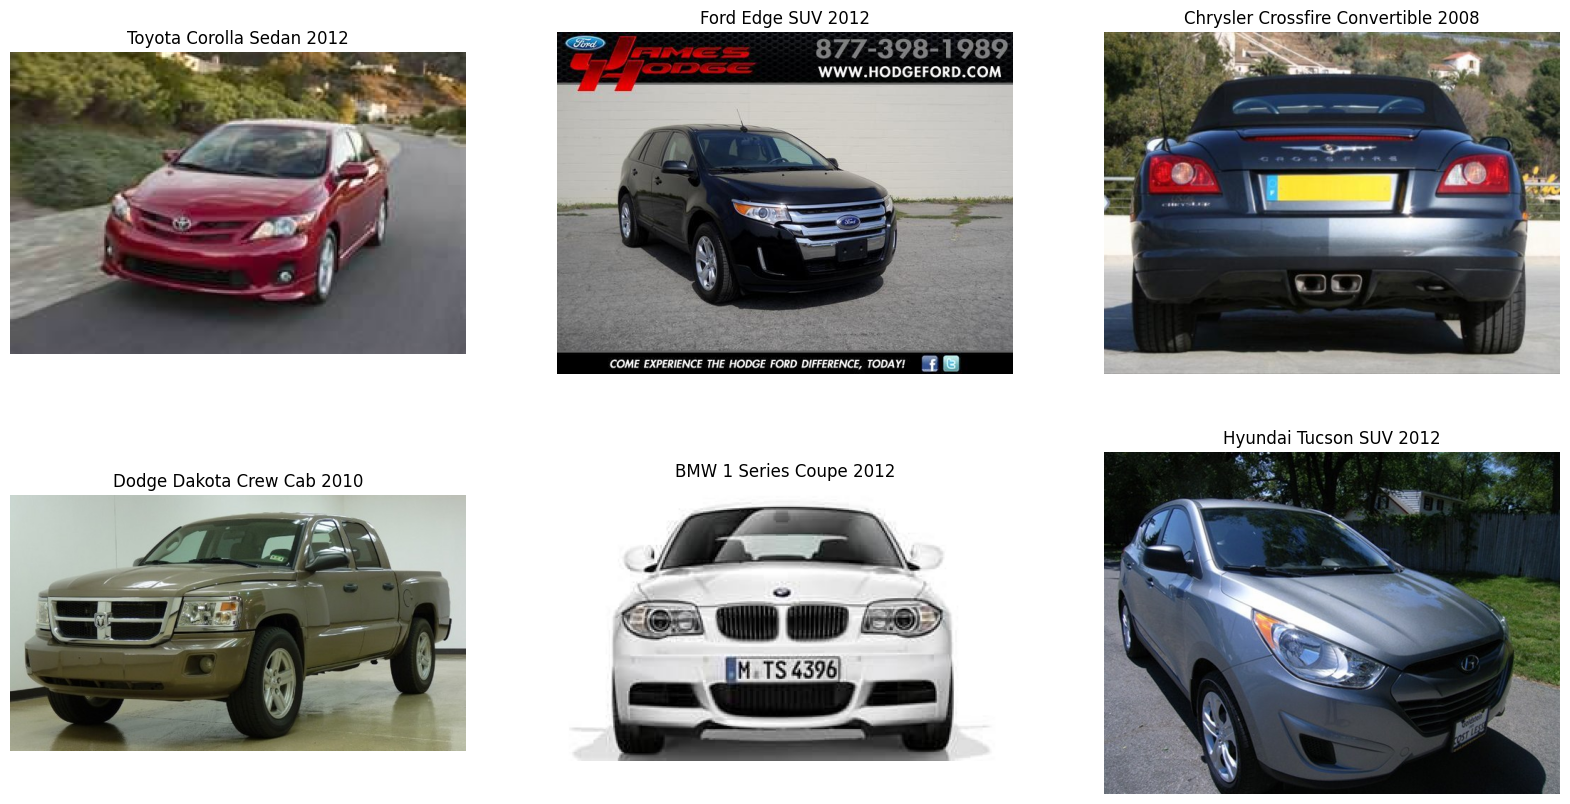

In [9]:
plot_samples(train)

In [10]:
num_classes = len(model_names)

# Target Sizes
TARGET_SIZE_224 = (224, 224)

# Batch Sizes
BATCH_SIZE_128 = 128
BATCH_SIZE_64 = 64
BATCH_SIZE_32 = 32
BATCH_SIZE_16 = 16
BATCH_SIZE_8 = 8


# Create Image Generators with different target sizes and batch sizes
train_gen_224, test_gen_224, val_gen_224 = create_img_generator(
    train_path=train_path,
    test_path=test_path,
    target_size=TARGET_SIZE_224)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.



In [11]:
# Clear session
tf.keras.backend.clear_session()

# Clear GPU memory
tf.compat.v1.reset_default_graph()

In [12]:
# Create TL ResNet50 Model
resnet50 = ResNet50_TL(input_shape=TARGET_SIZE_224 + (3,), num_classes=num_classes, see_summary=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [13]:
# Train Model
resnet50.train(train_gen_224, val_gen_224,
          epochs=100, batch_size=128, verbose=1, patience=6)

Model loaded


In [14]:
# Evaluate model
loss, acc = resnet50.evaluate(test_gen_224)

252/252 [==============================] - 104s 399ms/step - loss: 1.1230 - accuracy: 0.7065
Loss: 1.12
Accuracy: 70.65%


252/252 [==============================] - 115s 456ms/step


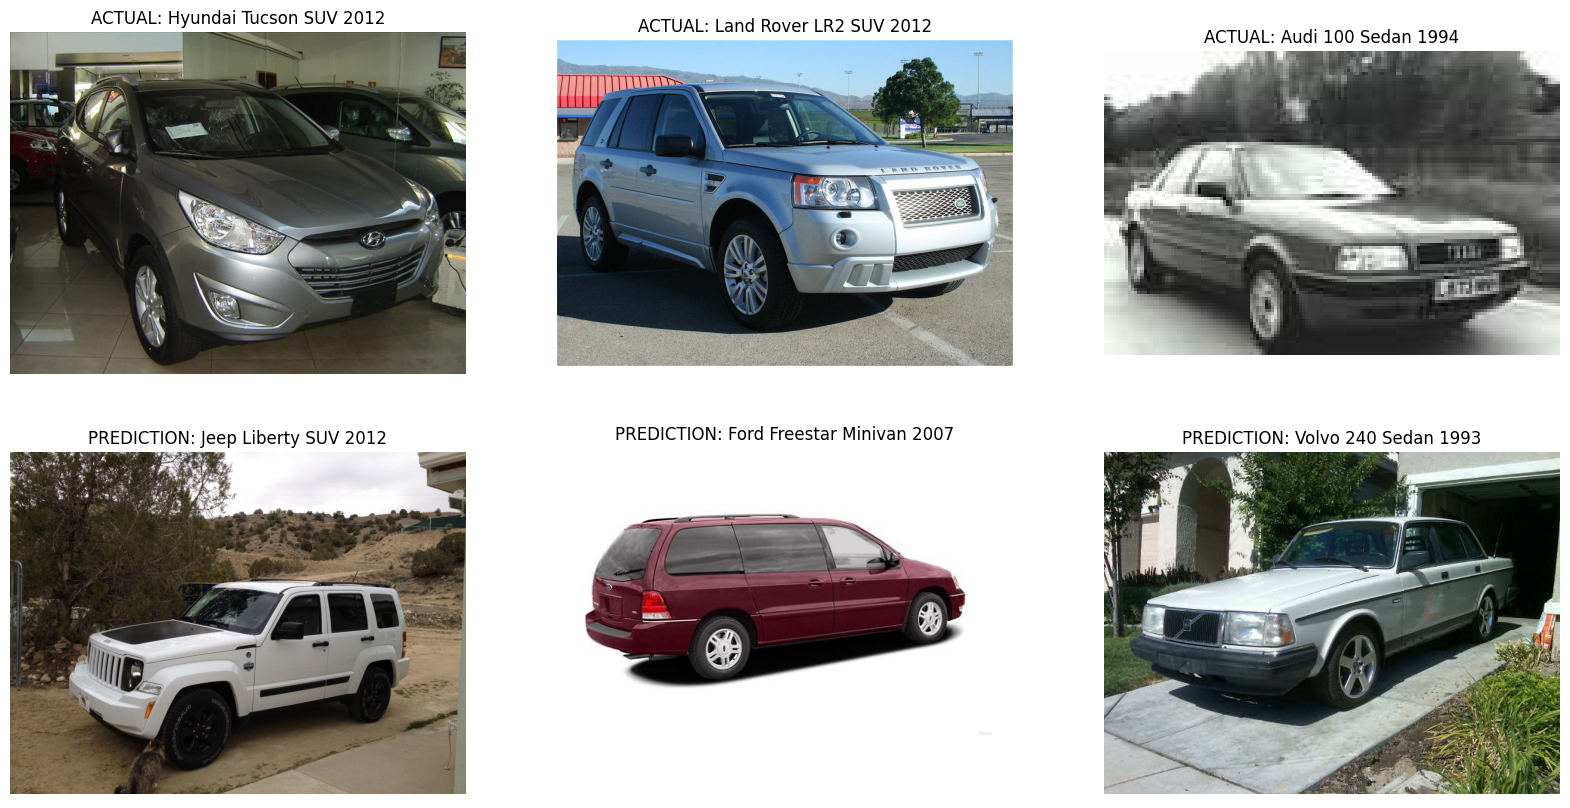

In [16]:
# Predictions
predictions = resnet50.predict(test_gen_224)
plot_comparison(df_test=test, model_names=model_names, predicted_classes=predictions)